# Optimising for adaptation as a circuit function through automatic gradient calculation

In order to find the derivative of adaptation, we need to be able to differentiate the dynamic simulation and the analytics calculated from it that are used to calculate adaptability. We need to be able to find the derivative of the sensitivity and precision with respect to the circuit topology. 

1. Set up a simple test circuit simulation environment
2. Re-write the dynamic simulation to keep track of the max / min of all species
3. Try to differentiate that

In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports 

In [100]:
from jax import jacrev
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import diffrax as dfx

from functools import partial
import os
import sys

jax.config.update('jax_platform_name', 'cpu')

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


np.random.seed(0)
jax.devices()

[CpuDevice(id=0)]

In [101]:
from synbio_morpher.srv.parameter_prediction.simulator import make_piecewise_stepcontrol
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation, compute_sensitivity, compute_precision, compute_peaks

# Test environment for example circuits

In [102]:
def make_species_bound(species_unbound):
    return sorted(set(flatten_listlike([['-'.join(sorted([x, y])) for x in species_unbound] for y in species_unbound])))


# RNA circuit settings
species_unbound = ['RNA_0', 'RNA_1', 'RNA_2']
species_bound = make_species_bound(species_unbound)
species = species_unbound + species_bound
species_signal = ['RNA_0']
species_output = ['RNA_1']
idxs_signal = [species.index(s) for s in species_signal]
idxs_output = [species.index(s) for s in species_output]
idxs_unbound = [species.index(s) for s in species_unbound]
idxs_bound = [species.index(s) for s in species_bound]
signal_onehot = np.array([1 if s in idxs_signal else 0 for s in np.arange(len(species))])

# Initial parameters
n_circuits = 100
n_circuits_display = 30
k = 0.00150958097
N0 = 200
y00 = np.array([[N0, N0, N0, 0, 0, 0, 0, 0, 0]]).astype(np.float32)
y00 = np.repeat(y00, repeats=n_circuits, axis=0)

# Simulation parameters
signal_target = 2
t0 = 0
t1 = 100
ts = np.linspace(t0, t1, 500)
dt0 = 0.0005555558569638981
dt1_factor = 5
dt1 = dt0 * dt1_factor
max_steps = 16**4 * 10

# Reactions
rates = np.array([[1e-4, 1e-4, 1e1],
                  [1e-4, 1e-6, 1e-4],
                  [1e1, 1e-4, 1e-4]])
rates = np.random.randint(-6, 2, size=(n_circuits, len(species_unbound), len(species_unbound)))
rates = np.exp(rates)

inputs = np.array([
    [2, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
])
outputs = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
])

# Rates
reverse_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], rates)))
forward_rates = np.ones_like(reverse_rates) * k

Text(0.5, 0.98, 'Jacobian of system')

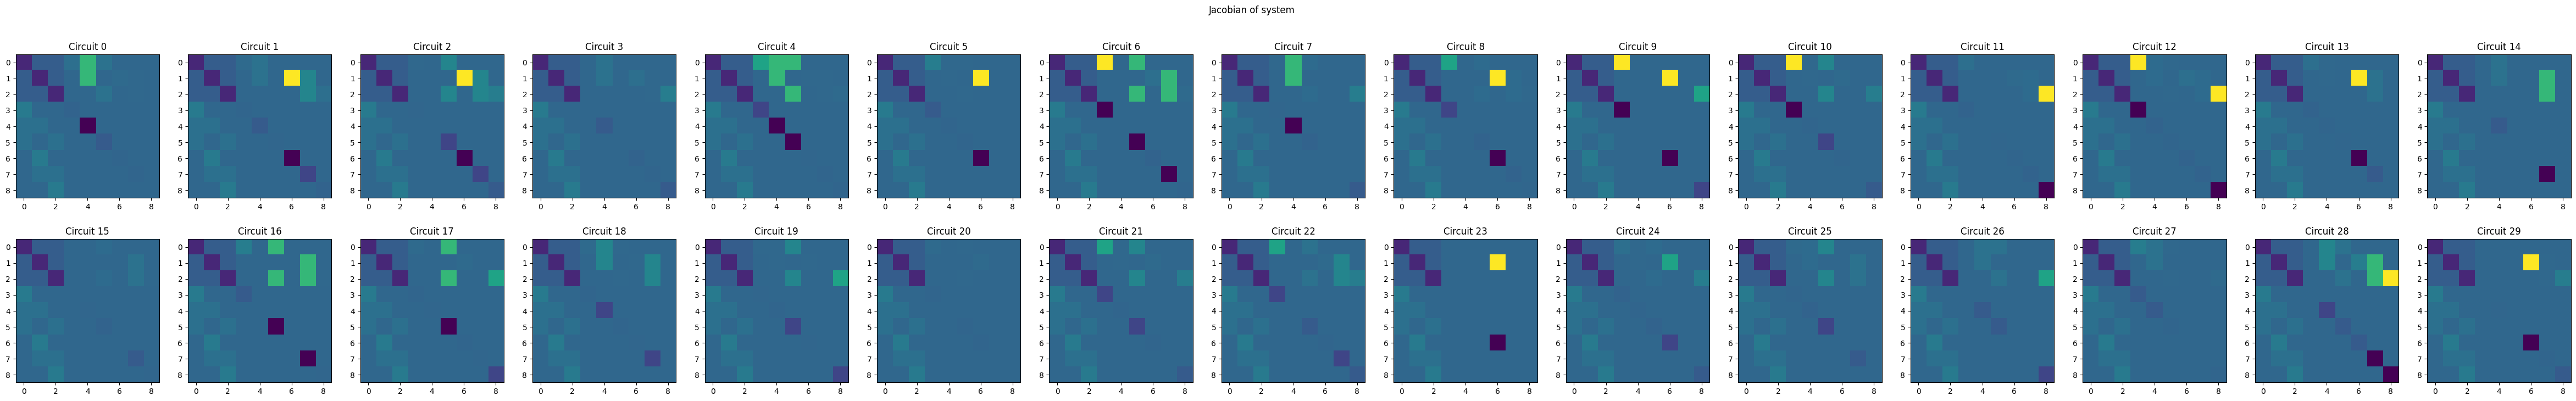

In [103]:
def one_step_de_sim_expanded(spec_conc, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = jnp.prod(
        jnp.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = jnp.prod(
        jnp.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


# bb = partial(bioreaction_sim_dfx_expanded,
#              t0=t0, t1=t1, dt0=dt0,
#              signal=None, signal_onehot=signal_onehot,
#              forward_rates=forward_rates,
#              inputs=inputs,
#              outputs=outputs,
#              solver=dfx.Tsit5(),
#              saveat=dfx.SaveAt(
#                  ts=ts),
#              max_steps=max_steps,
#              stepsize_controller=make_piecewise_stepcontrol(
#                  t0=t0, t1=t1, dt0=dt0, dt1=dt1)
#              )

Jbb = jax.vmap(jacrev(partial(one_step_de_sim_expanded,
                     forward_rates=forward_rates[0],
                     inputs=inputs,
                     outputs=outputs)))


sol_jac = Jbb(y00, reverse_rates=reverse_rates)

nr = 2
nc = int(np.ceil(n_circuits_display / nr))
fig = plt.figure(figsize=(4*nc, 4*nr))
for idx_circuit in range(n_circuits_display):
    ax = fig.add_subplot(nr, nc, idx_circuit+1)
    ax.set_title(f'Circuit {idx_circuit}')
    plt.imshow(sol_jac[idx_circuit])
    plt.clim([sol_jac.min(), sol_jac.max()])
plt.suptitle('Jacobian of system')

# Dynamic simulation

In [104]:
def one_step_de_sim_expanded(t, spec_conc, args, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = jnp.prod(
        jnp.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = jnp.prod(
        jnp.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


def wrap(y0,
         reverse_rates,
         solver=dfx.Tsit5(),
         saveat=dfx.SaveAt(
        ts=ts),
        max_steps=max_steps,
        stepsize_controller=make_piecewise_stepcontrol(
        t0=t0, t1=t1, dt0=dt0, dt1=dt1)):
    term = dfx.ODETerm(
        # jax.jacfwd(
            partial(one_step_de_sim_expanded,
                       forward_rates=forward_rates[0],
                       inputs=inputs,
                       outputs=outputs,
                       reverse_rates=reverse_rates)
            # )
    )
    return dfx.diffeqsolve(term, solver,
                           t0=t0, t1=t1, dt0=None,
                           y0=y0.squeeze(),
                           saveat=saveat, max_steps=max_steps,
                           stepsize_controller=stepsize_controller)
    


sol_steady_states = jax.vmap(wrap)(y00, reverse_rates)

y01 = np.array(sol_steady_states.ys[:, -1])
y01[:, np.array(idxs_signal)] = y00[:, np.array(idxs_signal)] * signal_target
sol_signal = jax.vmap(wrap)(y01, reverse_rates)

In [105]:
sol_full_ts = jnp.concatenate([sol_steady_states.ts, sol_signal.ts + sol_steady_states.ts.max()], axis=1)
sol_full_ys = jnp.concatenate([sol_steady_states.ys, sol_signal.ys], axis=1)

Text(0.5, 0.98, 'Dynamic of system')

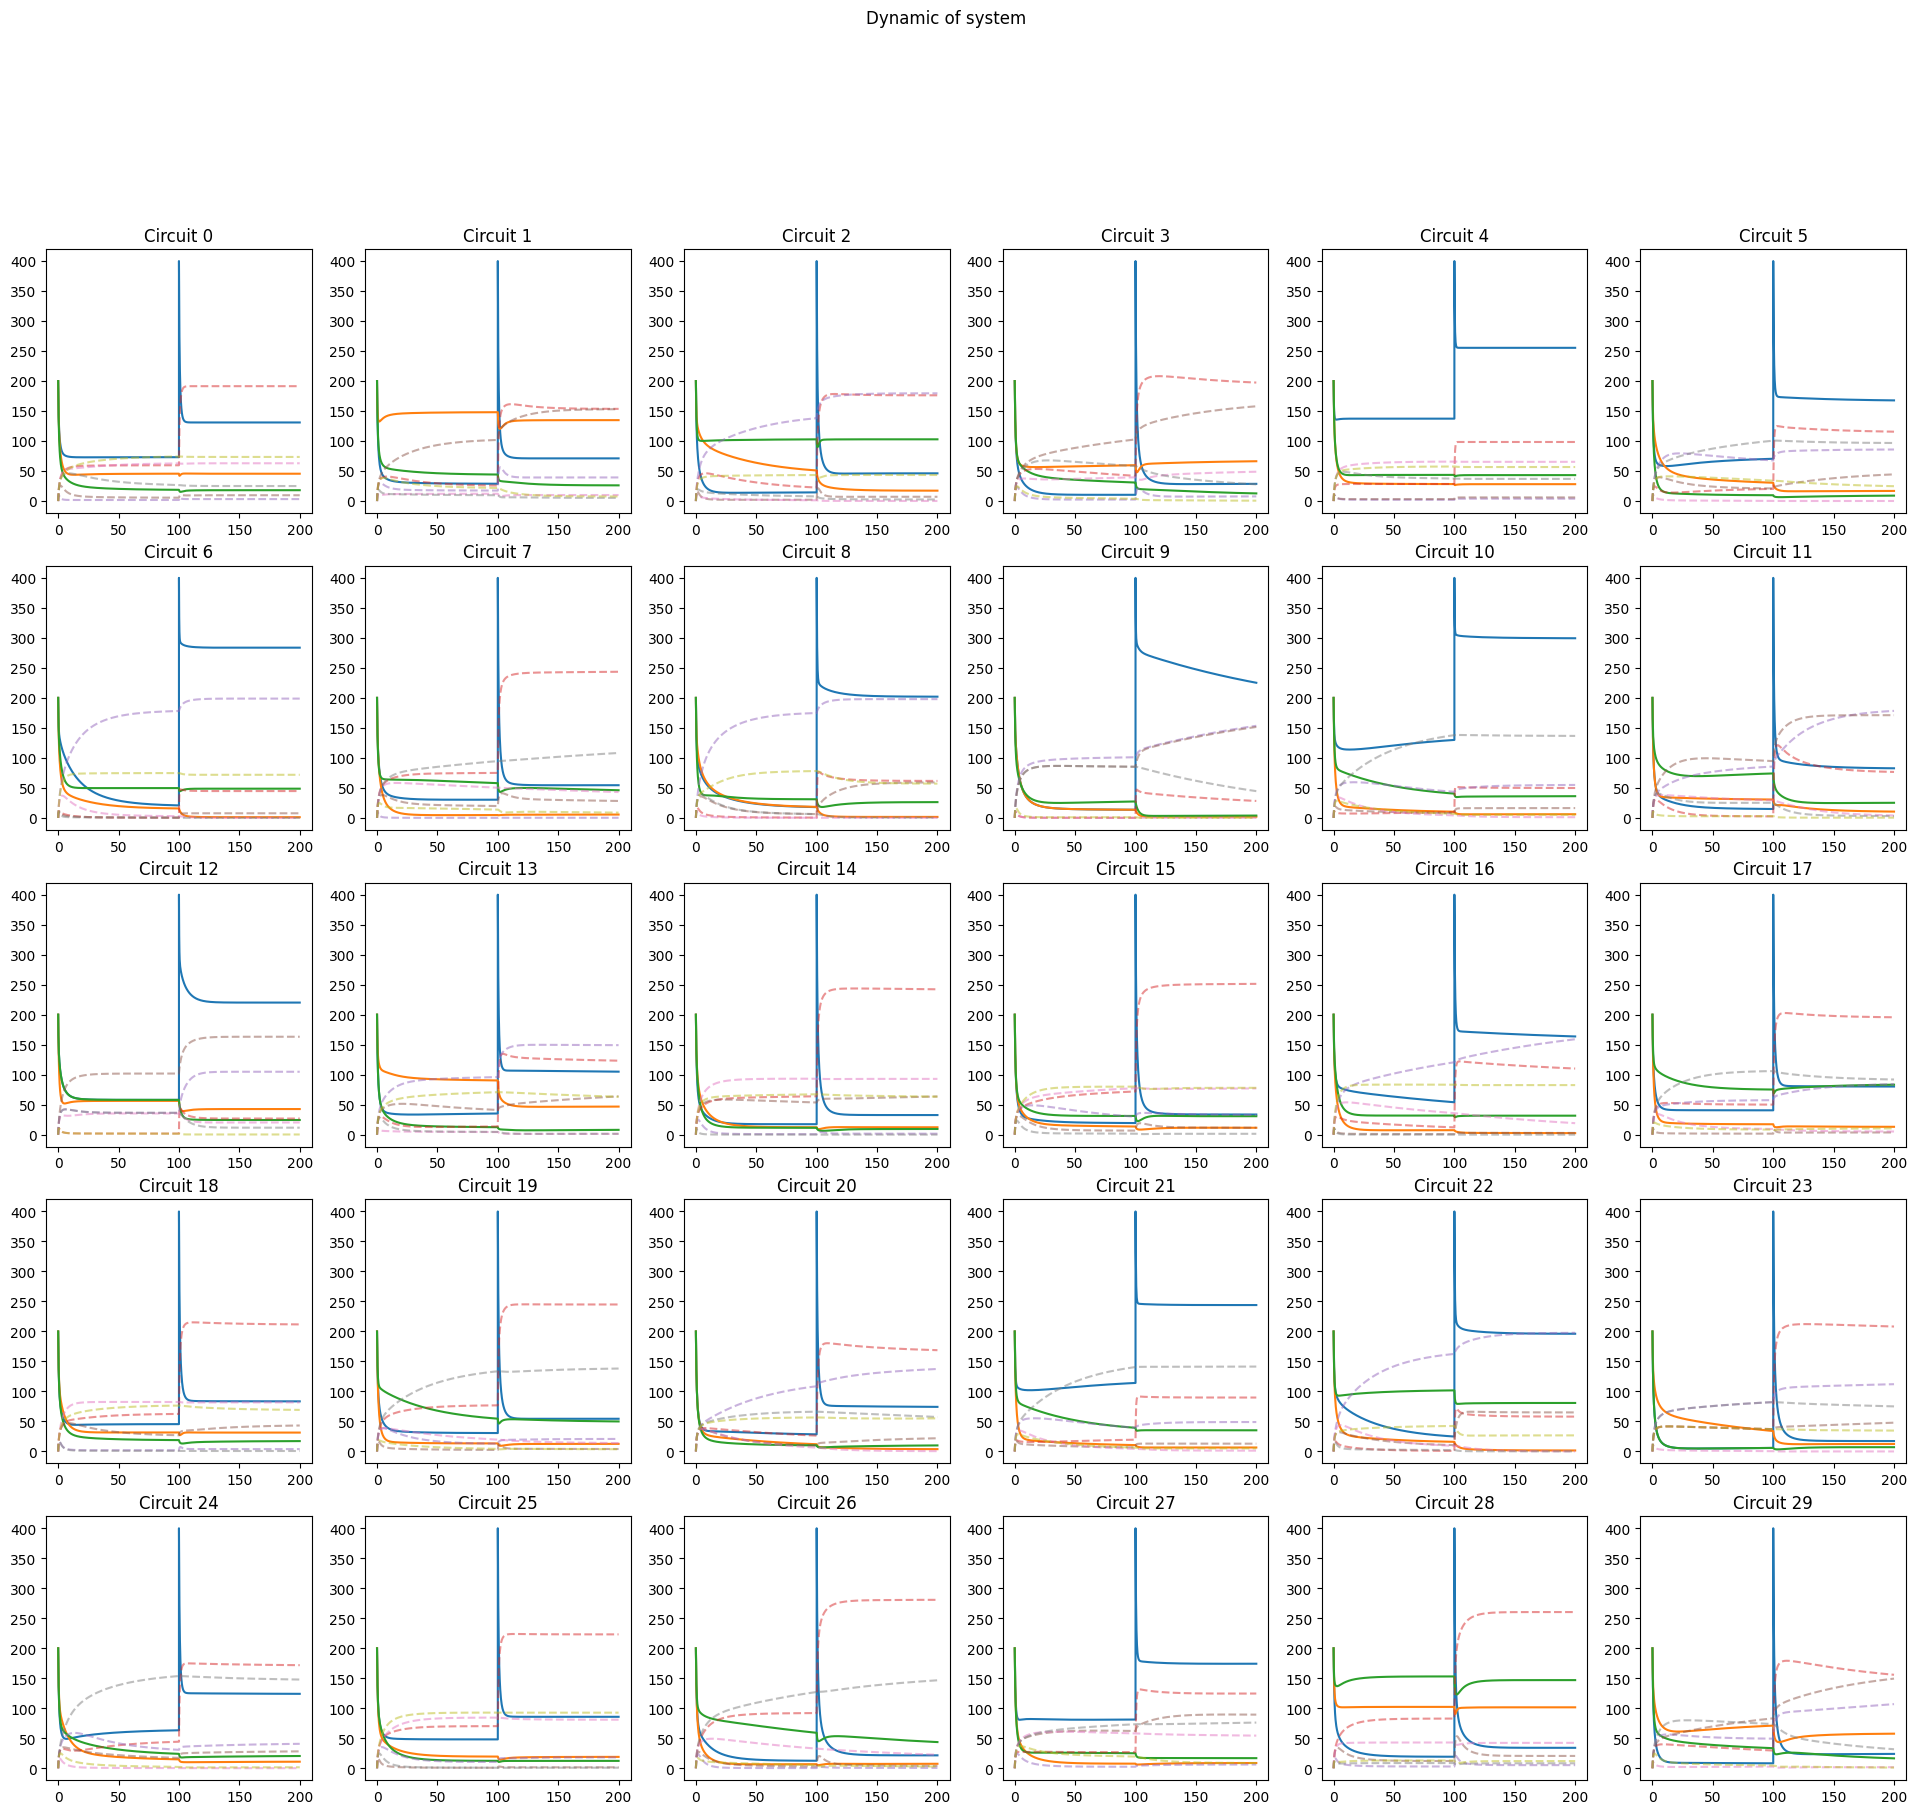

In [116]:
nc = int(np.ceil(np.sqrt(n_circuits_display)))
nr = int(np.ceil(np.sqrt(n_circuits_display)))
fig = plt.figure(figsize=(4*nc, 4*nr))
for idx_circuit in range(n_circuits_display):
    ax = plt.subplot(nr, nc, idx_circuit+1)
    ax.set_title(f'Circuit {idx_circuit}')
    # plt.plot(sol_signal.ts[idx_circuit], sol_signal.ys[idx_circuit], label=species)
    # plt.plot(sol_full_ts[idx_circuit], sol_full_ys[idx_circuit], label=species)
    plt.plot(sol_full_ts[idx_circuit], sol_full_ys[idx_circuit][:, np.array(idxs_unbound)], label=species_unbound)
    plt.plot(sol_full_ts[idx_circuit], sol_full_ys[idx_circuit][:, np.array(idxs_bound)], label=species_bound, alpha=0.5, linestyle='--')
plt.suptitle('Dynamic of system')

## Adaptation

In [139]:
def compute_adaptability_full(ys_steady, ys_signal, idx_sig):
    """ ts: time series with dimensions [t, species] """

    peaks = compute_peaks(ys_steady[-1], ys_signal[-1],
                          ys_signal.max(axis=0), ys_signal.min(axis=0))

    s = compute_sensitivity(
        signal_idx=idx_sig,
        starting_states=ys_steady[-1],
        peaks=peaks
    )
    p = compute_precision(
        starting_states=ys_steady[-1],
        steady_states=ys_signal[-1],
        signal_0=ys_steady[-1, idx_sig],
        signal_1=ys_signal[-1, idx_sig])
    a = calculate_adaptation(s, p)
    # a = jnp.log(a)
    
    return a, s, p


adaptability, sensitivity, precision = jax.vmap(partial(compute_adaptability_full, idx_sig=idxs_signal[0]))(
    sol_steady_states.ys, sol_signal.ys)

In [140]:
bad_circs = np.unique((np.where((((sensitivity - 1/precision)) < 0)[:, np.array(idxs_unbound)])[0]))
i = 0
bad_circs


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

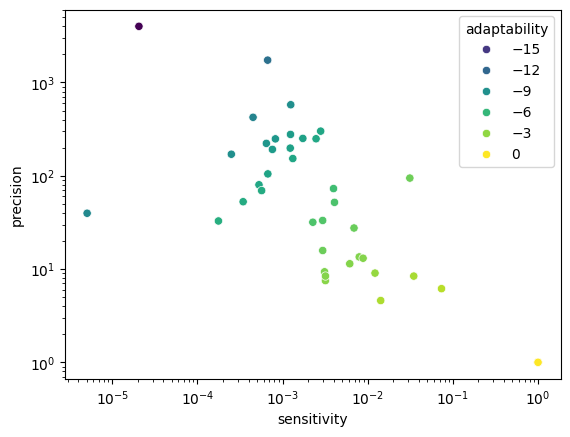

In [141]:
data = pd.DataFrame()
for a, a_name in zip([adaptability, sensitivity, precision], ['adaptability', 'sensitivity', 'precision']):
    data[a_name] = a.flatten()
data['species'] = species * n_circuits
data['idx_circuit'] = np.repeat(np.arange(n_circuits), len(species))

sns.scatterplot(data[data['species'].isin(species_unbound)], x='sensitivity', y='precision', hue='adaptability', palette='viridis')
# sns.scatterplot(data, x='sensitivity', y='precision', hue='adaptability', palette='viridis')
plt.xscale('log')
plt.yscale('log')

In [142]:
weird_circuits = np.where(adaptability[:, np.array(idxs_unbound)] < -0.12)[0]

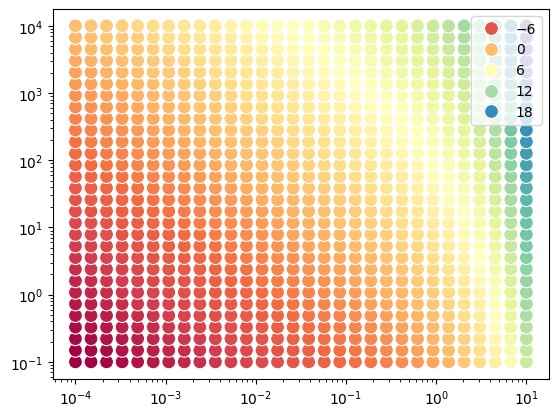

In [167]:
fake_s = np.power(10, np.linspace(-4, 1, 30))
fake_p = np.power(10, np.linspace(-1, 4, 30))
s, p = np.meshgrid(fake_s, fake_p)
a_raw = jax.vmap(lambda s, p: jnp.exp(s) * s * p)(s, p)
a = a_raw + np.abs(np.min(a_raw))*1.1
a = np.log(a)
# a = a_raw


sns.scatterplot(x=s.flatten(), y=p.flatten(), hue=a.flatten(), palette='Spectral', s=100)
plt.xscale('log')
plt.yscale('log')

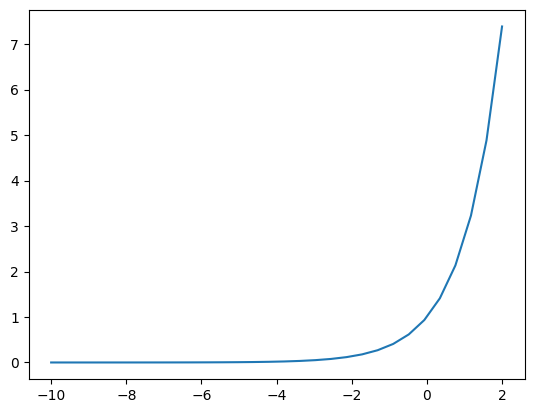

In [153]:
plt.plot(np.linspace(-10, 2, 30), np.exp(np.linspace(-10, 2, 30)))

In [96]:
p[np.where(a_raw == 0)], s[np.where(a_raw == 0)]
p[:, 0], s[0]

(array([1.00000000e+00, 1.37382380e+00, 1.88739182e+00, 2.59294380e+00,
        3.56224789e+00, 4.89390092e+00, 6.72335754e+00, 9.23670857e+00,
        1.26896100e+01, 1.74332882e+01, 2.39502662e+01, 3.29034456e+01,
        4.52035366e+01, 6.21016942e+01, 8.53167852e+01, 1.17210230e+02,
        1.61026203e+02, 2.21221629e+02, 3.03919538e+02, 4.17531894e+02,
        5.73615251e+02, 7.88046282e+02, 1.08263673e+03, 1.48735211e+03,
        2.04335972e+03, 2.80721620e+03, 3.85662042e+03, 5.29831691e+03,
        7.27895384e+03, 1.00000000e+04]),
 array([1.00000000e-04, 1.40694092e-04, 1.97948276e-04, 2.78501531e-04,
        3.91835201e-04, 5.51288979e-04, 7.75631025e-04, 1.09126703e-03,
        1.53534824e-03, 2.16014428e-03, 3.03919538e-03, 4.27596836e-03,
        6.01603487e-03, 8.46420566e-03, 1.19086373e-02, 1.67547492e-02,
        2.35729423e-02, 3.31657372e-02, 4.66622329e-02, 6.56510051e-02,
        9.23670857e-02, 1.29955033e-01, 1.82839054e-01, 2.57243747e-01,
        3.61926756e-01